### Lineare Regression auf dem Ames Housing Price Data Set 

Einmalige Installation notwendiger Pakete wird in VL 3 beschrieben. Verwendet werden hier die Bibliotheken pandas, numpy, matplotlib, seaborn, sklearn, imblearn, bokeh. Wenn nicht bereits geschehen, dann einmalig installieren.

##### Versionsgeschichte

    1.0 05.05.2023 Willi Hahn Initialversion
          Datenvorbereitung nach https://www.eamonfleming.com/projects/housing-regression.html
    1.1 05.06.2023 Willi Hahn Bokeh Plot Truth vs Prediction angefügt
    1.2 16.06.2023 Willi Hahn interactive Bokeh Plots
    1.2 23.10.2023 Willi Hahn Datenvorbereitung neu strukturiert. 
                         Eingabedaten werden nun in Ames EDA handcrafted.ipynb erstellt.
    1.5 13.08.2024 Willi Hahn update fixes für Bokeh
    1.6 15.07.2025 Willi Hahn Anpassung Pfade auf github, Korrektur variable var_impact,
                         Logging mit Datendatei erweitert.


In [1]:
# notwendige Bibliotheken importieren und konfigurieren
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import os # für dateiname = os.path.basename(pfad)
import matplotlib.pyplot as plt #Plot Bibliothek, wird auch von seaborn verwendet
import seaborn as sns #importing Seaborn (enhancement of Mathplotlib) for plots
from sklearn import metrics as met 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import bokeh   # graphische, interaktive Plots
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool, LassoSelectTool, Plot, WheelZoomTool, BoxZoomTool, ResetTool

# workaround für manchmal verschwindende Anzeige von Zellen in Standard Jupyter (nicht in Jupyterlab), Stand 07/2025
from IPython.display import display, HTML

display(HTML("""
<style>
div.output_scroll {
    overflow-y: auto;
    max-height: 500px;
}
</style>
"""))


scriptname='Ames LinReg.ipynb'
logtext=""
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    force=True,
    level=logging.INFO,
    format="%(asctime)s;%(levelname)s;%(message)s;",
    datefmt="%Y-%m-%d %H:%M:%S",
    encoding='utf-8',
    filemode='a',
    filename="AllScripts.log" # Default ist append
)
logger = logging.getLogger()


In [2]:
# Daten einlesen, siehe EDA Sript
path = 'c:/myBox/Projekte/python/Ames_Cleaned_26_v1.csv' # für lokale Dateien
#path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/Ames_Cleaned_26_v1.csv' # Stand 07/2025
df = pd.read_csv(path, sep=',') 
datendateiname = os.path.basename(path)
#df.info()

# Originaldaten einlesen für Unersuchungen der Vorhersagen
path = 'c:/myBox/Projekte/python/Daten/Ames/AmesHousing.csv' # für lokale Dateien
path = 'https://raw.githubusercontent.com/WilliHahn/FHDW/main/AmesHousing.csv'
df_org= pd.read_csv(path, sep=',') 


In [3]:
# Trainings- und Testdaten aufteilen

TESTANTEIL = 0.25 # Split der Test- und Trainingsdaten
# Trennung von unabhängigen Variablen und abhängiger Zielvariable
y = df['SalePrice']
x = df.drop(['SalePrice'], axis = 1)
#x.head().T
#y.head().T
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TESTANTEIL, random_state=4711)
dfx_test = pd.DataFrame(data=x_test, columns=x.columns) # Hilfe, um unskalierte Daten später in Bezug auf OrderNo zu zeigen
x_test.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
x_train.drop(columns=['Order'], inplace=True, axis=1) # jetzt erst eindeutigen Primärschlüssel entfernen
# und prüfen durch ansehen
#print (x_train.shape)
#print (y_train.shape)
#print (x_test.shape)
#print (y_test.shape)
#x_train.info()



In [4]:
# Datenvorbereitung : Variablen skalieren
SCALER = StandardScaler()
#SCALER = MinMaxScaler()
scalerklassenname = type(SCALER).__name__

x_train = SCALER.fit_transform(x_train)
x_test = SCALER.transform(x_test)
#
#x_test.T

In [5]:
# Lineare Regression berechnen
t0 = timer()

regressor = LinearRegression()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

t1 = timer()
print ('Laufzeit Vorhersage = ', round(t1 - t0, 0), ' sec')

# EVALUATING MODEL METRICS
mae = mean_absolute_error(y_test, y_pred)
print("MAE =", mae)
mse = mean_squared_error(y_test,y_pred)
print("MSE",mse)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("RMSE",rmse)
r2 = r2_score(y_test,y_pred)
print('Model Score R2: ', r2)
adjusted_r2 = 1 - (1-r2)*(len(y_pred)-1)/(len(y_pred)-x_test.shape[1]-1)
print('Model Score R2 Adjusted: ', adjusted_r2)
#print('\n\nCoefficients: ', regressor.coef_)
#print('Intercept: ',regressor.intercept_)

df_comparison = pd.DataFrame({"Actual":y_test,"Predicted":y_pred}) # für späteren Gebrauch in interaktiven plots.

logging.info(scriptname + ';' + datendateiname + ';' + scalerklassenname + "; Data Frame: "+str(df.shape[0])+ ";"+ str(df.shape[1])+ 
             "; Testanteil: "+ f'{TESTANTEIL:9.2f}'+ ";")
logging.info(scriptname + '; MAE=' + f'{mae:9.0f}' + "; RMSE=" + f'{rmse:9.0f}'+ "; R2=" + f'{r2:9.4f}'+ "; R2 adj.="+ 
             f'{adjusted_r2:9.4f}'+ ";")
zipped=zip(x.columns,regressor.coef_)
tmpString="Intercept="+f'{regressor.intercept_:4.3f}' +", "
while True:
    try:
        tup=next(zipped)
        tmpString=tmpString+tup[0] +"->" + f'{tup[1]:4.2f}'+", "
    except StopIteration:
        break
logging.info(scriptname + ';' +str(list(x.columns))+ ";")
logging.info(scriptname + ';' +tmpString+ ";")


Laufzeit Vorhersage =  0.0  sec
MAE = 18430.25388146336
MSE 662785639.050039
RMSE 25744.623497927467
Model Score R2:  0.8766555025978028
Model Score R2 Adjusted:  0.8716911729809961


In [6]:
#!cat ./AllScripts.log  # show log file on Colab or Linux
#!type .\AllScripts.log # show log file on Windows

In [7]:
# Regressionskoeffizienten und 1-unit change und die leider mangelnde Erklärbarkeit
print('Intercept: ',regressor.intercept_)
x_without_order = x.drop(columns=['Order'], axis=1)
var_impact = pd.DataFrame(data=[x_without_order.columns, regressor.coef_]).T
var_impact.columns = ["Variable", "1-unit change"]
var_impact

Intercept:  183827.43430837878


,Variable,1-unit change
0,Bsmt Qual,6326.966694
1,Exter Qual,13527.987616
2,Fireplace Qu,4374.536813
3,Functional,3740.257627
4,Garage Area,8365.247479
5,Garage Qual,-2381.821944
6,Gr Liv Area,30327.275124
7,HouseAge,-8333.929993
8,TotalPorchSF,1559.538974
9,Kitchen Qual,10677.33488


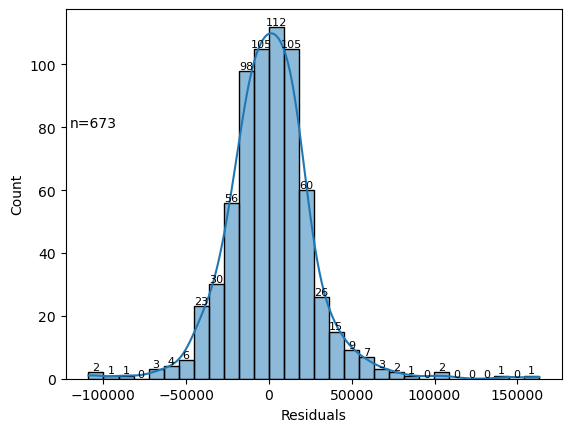

In [8]:
# Sind die die Residuen zwischen wirklichen und vorhergesagten Verkaufspreisen normalverteilt?
residuals = y_test - y_pred
y = sns.histplot(residuals, bins=30, stat='count', element="bars", kde=True)
_ = y.bar_label(y.containers[0], fontsize = 8)
_ = plt.xlabel('Residuals')
_ = plt.text(-120000,80,"n=" + str (df_comparison.shape[0]),color='black')
#plt.scatter(y=residuals, x=data['x'])
#plt.ylabel('Residuals')
#plt.xlabel('Independent variable x')
plt.show()
logging.info(scriptname + '; Residuals min,max, Skew, Curtosis;' + f'{residuals.min():9.0f}' + 
             ";" + f'{residuals.max():9.0f}'+ ";"  + f'{residuals.skew():2.4f}'+ ";"  + f'{residuals.kurtosis():2.4f}'+ ";" )


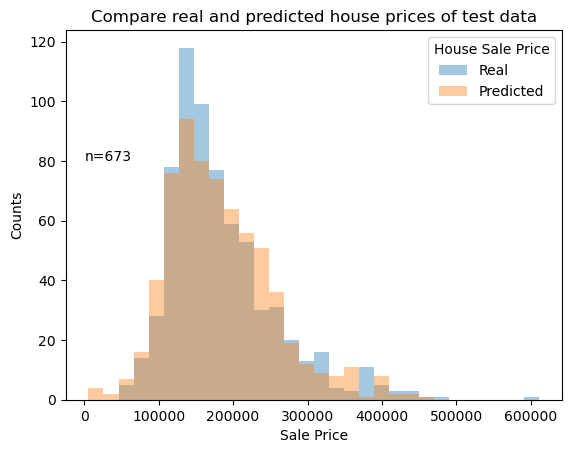

In [9]:
# Vergleich der Verteilungen für real und predicted house prices
fig, axes = plt.subplots(1)

min_value = min(df_comparison['Actual'].min(), df_comparison['Predicted'].min())
max_value = max(df_comparison['Actual'].max(), df_comparison['Predicted'].max())
bins = np.linspace(min_value, max_value, 31)  # 30 gleichmäßige Bins

plt.rcParams["figure.autolayout"] = True
_ = plt.hist(df_comparison['Actual'],bins=bins, alpha=.4)
_ = plt.xlabel('Sale Price');
_ = plt.text(1.8,80,"n=" + str (df_comparison.shape[0]),color='black')
_ = plt.hist(df_comparison['Predicted'],bins=bins, alpha=.4)
_ = plt.xlabel('Sale Price');
_ = plt.ylabel('Counts');
_ = plt.title('Compare real and predicted house prices of test data');
_ = plt.legend(title='House Sale Price', loc='upper right', labels=['Real', 'Predicted'])

plt.show()


In [10]:
# Zeichne wahre Hauspreise gegen Vorhersagen, mit tool tips der Datenpunkte
# verwende interaktive plots aus bokeh

output_notebook(resources=None, verbose=True, hide_banner=True)

df_tip=pd.concat([df_comparison,dfx_test], axis=1, join='inner') 
df_tip['Order'] = dfx_test['Order'].astype('int64')

source = ColumnDataSource(df_tip)

hover = HoverTool(
        tooltips=[
            ("OrderNo", "@Order")
             , ("Sale Price Actual", "@Actual{0}")
             , ("Sale Price Predicted", "@Predicted{0}")
             , ("House Age", "@HouseAge{0}")
             , ("Remodel Age", "@RemodelAge{0}")
             , ("Lot Area", "@{Lot Area}{0}")
             , ("Living Area", "@{Gr Liv Area}{0}")
             , ("Bathrooms", "@TotalBathrooms{0.0}")
             , ("NeighborhoodClass", "@NeighborhoodClass")
        ]
    )

p = figure(width=800, height=400, tools=[hover],
           title="Actual vs predicted Sale Price (see tool tip)", x_range=(0, 700000), 
               y_range=(0, 700000),
           toolbar_location="right", toolbar_sticky=False)
p.xaxis.axis_label = 'Actual Sale Price'
p.yaxis.axis_label = 'Predicted Sale Price'
p.left[0].formatter.use_scientific = False
p.below[0].formatter.use_scientific = False
_ = p.scatter ('Actual', 'Predicted', size=6, source=source)
_ = show(p)

#df_test.loc[df_test["Order"] == 433].T  # Testdatensatz ansehen, um die Tooltips zu prüfen